### Esercitazione 25 - Analisi Dinamica Profili Volumetrici
#### Argomenti

* Analisi dell'andamento dei livelli di prezzo evidenziati dall'analisi dei profili volumetrici
* Creazione di grafici custom e di animazioni per analizzare l'evoluzione del mercato

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pickle
import matplotlib.pyplot as plt
from market_profile import MarketProfile
from IPython.display import clear_output
import imageio
import glob
import os
import shutil

In [2]:
candles = pickle.load(open('BTC-USD_M1.pck', 'rb'))

In [3]:
# cambio iniziale alle colonne del dataframe [candles]
# per compatibilità con MaketProfile
candles.rename(columns={'close': 'Close', 'open': 'Open', 'high': 'High', 'low': 'Low', 'volume': 'Volume'}, inplace=True)

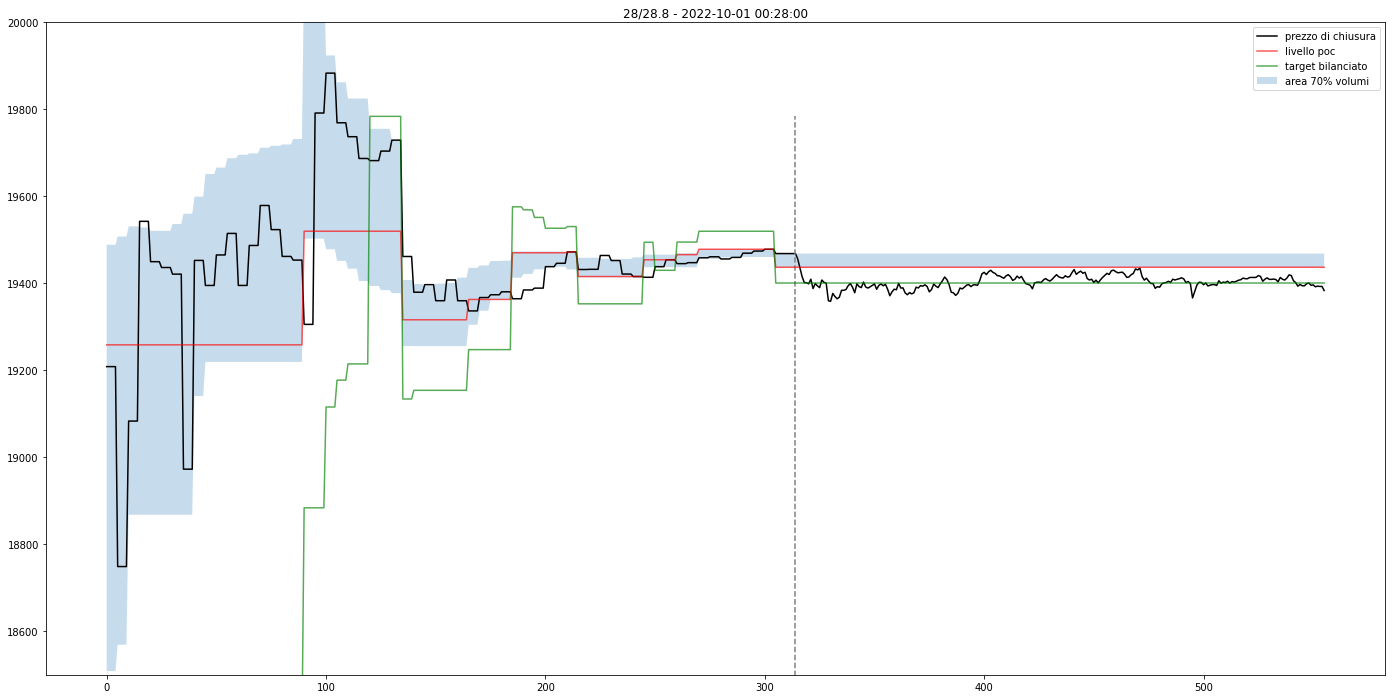

In [4]:
dt = datetime(2022, 10, 1, 0, 0, 0)
cnt = 0
giorni_animazione = .02  # 28 minuti

# intervalli su cui calcolare i profili volumetrici
ore_da_testare = []
start_h = 72
while start_h > 0.1:
    ore_da_testare.append(start_h)
    start_h = start_h - start_h * 0.1

while cnt < int(60 * 24 * giorni_animazione):
    data_inizio_test = dt
    data_inizio_test_appo = dt
    res = []
    for ora_idx, ora_da_testare in enumerate(ore_da_testare):
        data_inizio_train = data_inizio_test - timedelta(hours=ora_da_testare)
        actions = []
        position = 0

        mp = MarketProfile(candles[data_inizio_test - timedelta(days=np.max(ore_da_testare) + 1):data_inizio_test - timedelta(minutes=1)])
        mp_slice = mp[data_inizio_train:data_inizio_test - timedelta(minutes=1)]
        ultimo_prezzo_di_chiusura = candles[data_inizio_train:data_inizio_train + timedelta(minutes=1)].Close[0]
        for rep in range(5):
            res.append([
                ultimo_prezzo_di_chiusura,
                mp_slice.poc_price,
                mp_slice.balanced_target,
                mp_slice.value_area[0],
                mp_slice.value_area[1],
                ora_idx * 5 + rep
            ])

    data_inizio_test += timedelta(minutes=1)
    data_inizio_test_appo = data_inizio_test
    ora_idx = ora_idx * 5 + 4

    while ora_idx < (len(ore_da_testare) * 5) + (60 * 4):
        data_inizio_test += timedelta(minutes=1)
        ultimo_prezzo_di_chiusura = candles[data_inizio_test:data_inizio_test + timedelta(minutes=1)].Close[0]
        ora_idx += 1
        res.append([
            ultimo_prezzo_di_chiusura,
            mp_slice.poc_price,
            mp_slice.balanced_target,
            mp_slice.value_area[0],
            mp_slice.value_area[1],
            ora_idx
        ])
    xs = [x[-1] for x in res]
    clear_output(wait=True)

    cnt += 1

    plt.figure(figsize=(24, 12))
    plt.plot(xs, [x[0] for x in res], label='prezzo di chiusura', color='black')
    plt.vlines(xs[(len(ore_da_testare) * 5) - 1], ymin=np.min([x[2] for x in res]), ymax=np.max([x[2] for x in res]), color='gray', linestyle='--')
    plt.plot(xs, [x[1] for x in res], label='livello poc', alpha=0.66, color='red')
    plt.plot(xs, [x[2] for x in res], label='target bilanciato', alpha=0.66, color='green')
    plt.fill_between(xs, y1=[x[3] for x in res], y2=[x[4] for x in res], label='area 70% volumi', alpha=0.25)
    plt.ylim(18500, 20000)
    plt.legend()
    plt.savefig('img/' + str(int(cnt)) + '.png')
    plt.title(str(cnt) + '/' + str(60 * 24 * giorni_animazione) + ' - ' + str(data_inizio_test_appo))
    plt.show()

    dt += timedelta(minutes=1)

fp_in = "img/*.png"
fp_out = 'animation.gif'

with imageio.get_writer(fp_out, mode='I', duration=.04) as writer:
    for filename in sorted(glob.glob(fp_in)):
        image = imageio.imread(filename)
        writer.append_data(image)

folder = 'img/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('impossibile cancellare %s.\nMotivazione: %s' % (file_path, e))